# **Instalación de las Librerías**

In [3]:
#!pip3 install pyramid.arima
#!pip install pyramid

In [4]:

import os
import pandas as pd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
color = sns.color_palette()
import random
%matplotlib inline
import io

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from google.colab import files


from pandas import Series
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# **Carga y Limpieza de Datos**

In [5]:
uploaded = files.upload()

Saving train_join_inventario_711.csv to train_join_inventario_711.csv


In [191]:
train = pd.read_csv(io.BytesIO(uploaded['train_join_inventario_711.csv']), usecols=[0, 2, 3, 4, 5, 6, 7, 8, 9,10, 11])
train.head()

,date,store_nbr,nombre_item,item_nbr,clasificacion,subclasificacion,family,unidades,precio,unit_sales,onpromotion
0,2020-01-07,711,MAGGI MOSTAZA,7861001236101,1066-MOSTAZAS,0020-BASICA,10-COMESTIBLES I,84,0.57,20,False
1,2019-07-10,711,MAGGI CRIOLLITA GALLINA GRATIS 2 SOBRES,7861001238013,1022-CALDOS,0030-POLVO,10-COMESTIBLES I,136,1.19,11,False
2,2019-09-25,711,MAGGI CALDO GALLINA,7861001299205,1022-CALDOS,0010-CUBO,10-COMESTIBLES I,140,2.16,25,False
3,2019-06-22,711,RANCHERO CALDO GALLINA,7861002386997,1022-CALDOS,0030-POLVO,10-COMESTIBLES I,144,1.79,18,True
4,2019-03-30,711,MAGGI CRIOLLITA GALLINA,7861001231991,1022-CALDOS,0030-POLVO,10-COMESTIBLES I,27,7.94,1,False


Existen unidades vendidas negativas por el tema de devoluciones , por lo que en donde se encuentren negativos dejarlos con un valor de 0.

In [192]:
train['unit_sales'] = np.where(train['unit_sales']<=0, 0, train['unit_sales'])

Por temas de feriados en Diciembre y por el paro nacional ocurrido en el año 2019, no se abrieron los locales. Por tanto hay que rellenar con datos las fechas faltantes.

In [193]:
concat = pd.DataFrame({"date":['2019-12-25', '2020-01-01', '2019-10-13'], 
                       "store_nbr":[711, 711, 711],
                       "item_nbr":[7861001238013, 7861001238013, 7861001238013],
                       "clasificacion":['1022-CALDOS', '1022-CALDOS', '1022-CALDOS'], 
                       "subclasificacion":['0030-POLVO', '0030-POLVO',  '0030-POLVO'],
                       "family":['10-COMESTIBLES I', '10-COMESTIBLES I',  '10-COMESTIBLES I'],
                       "unidades":[136, 136, 136], 
                       "precio":[1.19, 1.19, 1.19],
                       "unit_sales":[1, 1, 1],
                       "onpromotion":[False, False, False] }) 
train = train.append(concat)                     

Exploremos el tipo de dato existente para cada columna.

In [194]:
train.dtypes

date                 object
store_nbr             int64
nombre_item          object
item_nbr              int64
clasificacion        object
subclasificacion     object
family               object
unidades              int64
precio              float64
unit_sales            int64
onpromotion            bool
dtype: object

Se tiene que cambiar el tipo de dato de ciertas columnas 

In [195]:
# Conviertiendo a formato de fecha la columna 'date'
train['date']=pd.to_datetime(train['date'],format="%Y-%m-%d")

# Conviertiendo a formato object la columna 'store_nbr'
train['store_nbr'] = train['store_nbr'].astype(object)

# Conviertiendo a formato object la columna 'item_nbr'
train['item_nbr'] = train['item_nbr'].astype(np.object)

# Conviertiendo a formato float la columna 'unit_sales'
train['unit_sales'] = train['unit_sales'].astype('float64')

# Conviertiendo a formato float la columna 'precio'
train['precio'] = train['precio'].astype('float64')


Se añadieron nuevas columnas a partir de la fecha

In [196]:
train['year'] = pd.DatetimeIndex(train['date']).year
train['month'] = pd.DatetimeIndex(train['date']).month
train['day'] =pd.DatetimeIndex(train['date']).day.astype(np.uint8)

train['day']=train['day'].astype(np.uint8)
train['month']=train['month'].astype(np.uint8)
train['year']=train['year'].astype(np.uint16)

In [197]:
#Separando en conjunto de train y conjunto de test

train_split = train[train['date']<='2020-01-14']
test_split = train[train['date']>='2020-01-15']

# **Descripción general de los datos**

In [13]:
train_split.describe()

,unidades,precio,unit_sales,year,month,day
count,1.271090e+06,1.271090e+06,1.271090e+06,1.271090e+06,1.271090e+06,1.271090e+06
mean,2.416066e+01,3.158139e+00,5.289663e+00,2.019039e+03,6.792781e+00,1.530902e+01
std,2.685035e+01,3.783031e+00,1.143375e+01,1.927903e-01,3.298473e+00,8.851858e+00
min,1.000000e+00,1.000000e-02,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00
25%,1.200000e+01,1.350000e+00,1.000000e+00,2.019000e+03,4.000000e+00,8.000000e+00
50%,2.100000e+01,2.240000e+00,3.000000e+00,2.019000e+03,7.000000e+00,1.500000e+01
75%,2.400000e+01,3.610000e+00,6.000000e+00,2.019000e+03,1.000000e+01,2.300000e+01
max,5.880000e+02,8.282000e+01,1.527000e+03,2.020000e+03,1.200000e+01,3.100000e+01


In [14]:
train_split.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271090 entries, 0 to 2
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   date              1271090 non-null  datetime64[ns]
 1   store_nbr         1271090 non-null  object        
 2   nombre_item       1271087 non-null  object        
 3   item_nbr          1271090 non-null  object        
 4   clasificacion     1271090 non-null  object        
 5   subclasificacion  1271090 non-null  object        
 6   family            1271090 non-null  object        
 7   unidades          1271090 non-null  int64         
 8   precio            1271090 non-null  float64       
 9   unit_sales        1271090 non-null  float64       
 10  onpromotion       1271090 non-null  bool          
 11  year              1271090 non-null  uint16        
 12  month             1271090 non-null  uint8         
 13  day               1271090 non-null  uint8       

In [ ]:
# Observando valores perdidos
train_split.isna().sum()

date                0
store_nbr           0
nombre_item         3
item_nbr            0
clasificacion       0
subclasificacion    0
family              0
unidades            0
precio              0
unit_sales          0
onpromotion         0
year                0
month               0
day                 0
dtype: int64

# **Visualizaciones de la distribución de unit_sales**

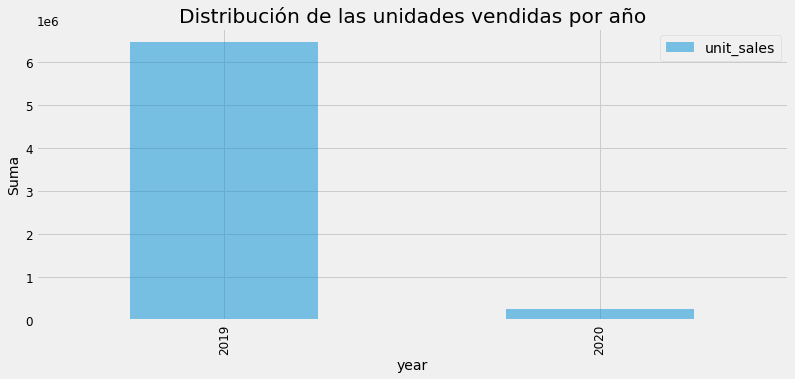

In [ ]:
_ = train_split.groupby("year").aggregate({"unit_sales": "sum"}).plot(kind="bar", alpha=.5, figsize=(12, 5))
_ = plt.title("Distribución de las unidades vendidas por año")
_ = plt.ylabel("Suma")

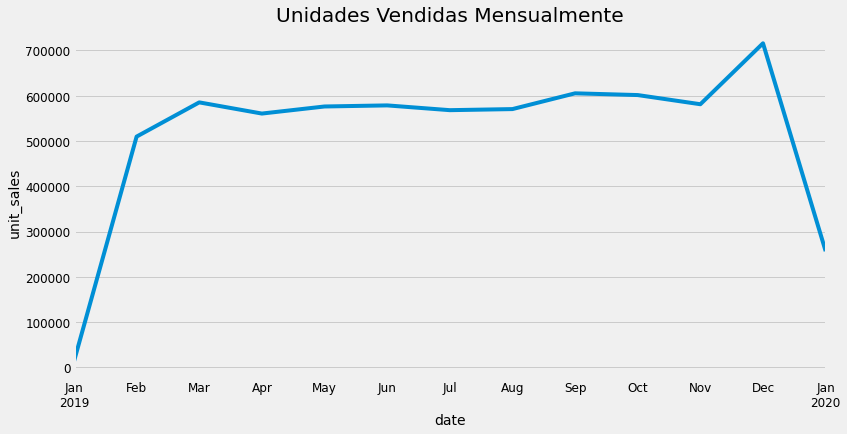

In [ ]:
# Ventas Mensuales
ax = train_split.set_index("date")["unit_sales"].resample("M").sum().plot(figsize=(12, 6))
_ = ax.set_ylabel("unit_sales")
_ = ax.set_title("Unidades Vendidas Mensualmente")

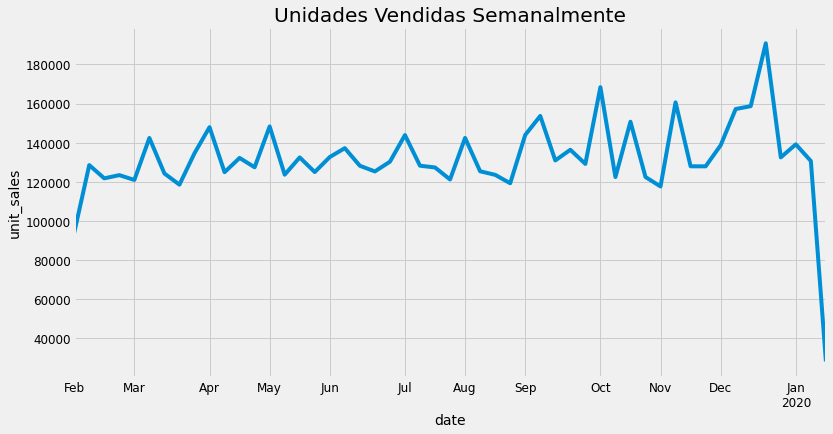

In [ ]:
ax = train_split.set_index("date")["unit_sales"].resample("W").sum().plot(figsize=(12, 6))
_ = ax.set_ylabel("unit_sales")
_ = ax.set_title("Unidades Vendidas Semanalmente")

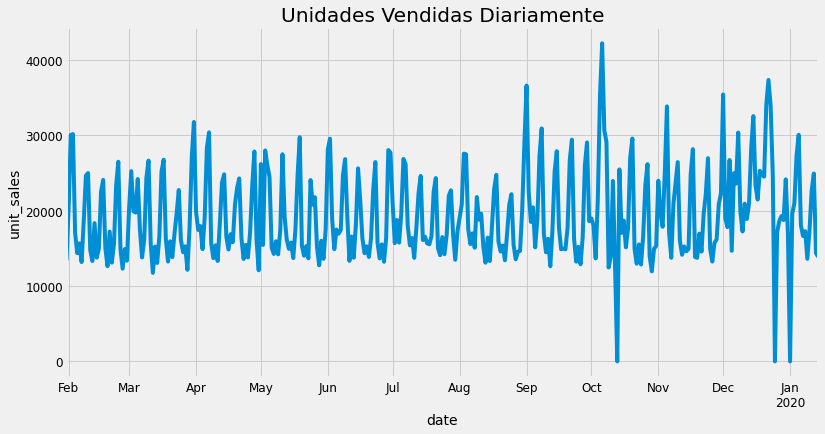

In [ ]:
ax = train_split.set_index("date")["unit_sales"].resample("D").sum().plot(figsize=(12, 6))
_ = ax.set_ylabel("unit_sales")
_ = ax.set_title("Unidades Vendidas Diariamente")

Observando el gráfico previo, se puede observarq que las unidades vendidas diariamente tienen un comportamiento más o menos uniforme que puede ser modelado con una serie temporal.

Para esto, primero observemos el histograma de las unidades diarias vendidas:

In [15]:
y = train_split.set_index("date")["unit_sales"].resample("D").sum()
df = y.to_frame()

In [16]:
df

,unit_sales
date,
2019-01-31,13401.0
2019-02-01,20371.0
2019-02-02,30048.0
2019-02-03,30165.0
2019-02-04,17045.0
...,...
2020-01-10,17384.0
2020-01-11,22676.0
2020-01-12,24934.0


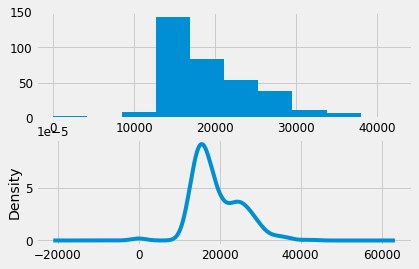

In [17]:
pyplot.figure(1)
pyplot.subplot(211)
y.hist()
pyplot.subplot(212)
y.plot(kind='kde')
pyplot.show()

# **Modelos**

## **ARIMA**

### Gráfico de la serie temporal

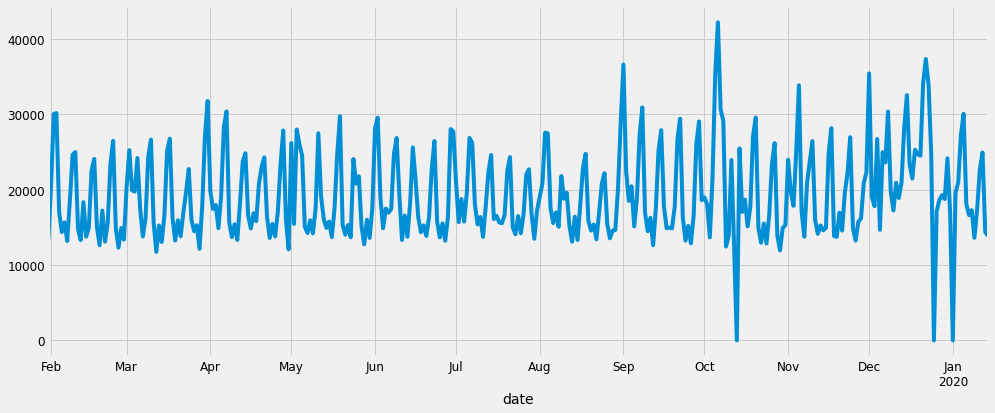

In [ ]:
# plot serie temporal
y.plot(figsize=(15, 6))
plt.show()

### Estacionalidad de la Serie

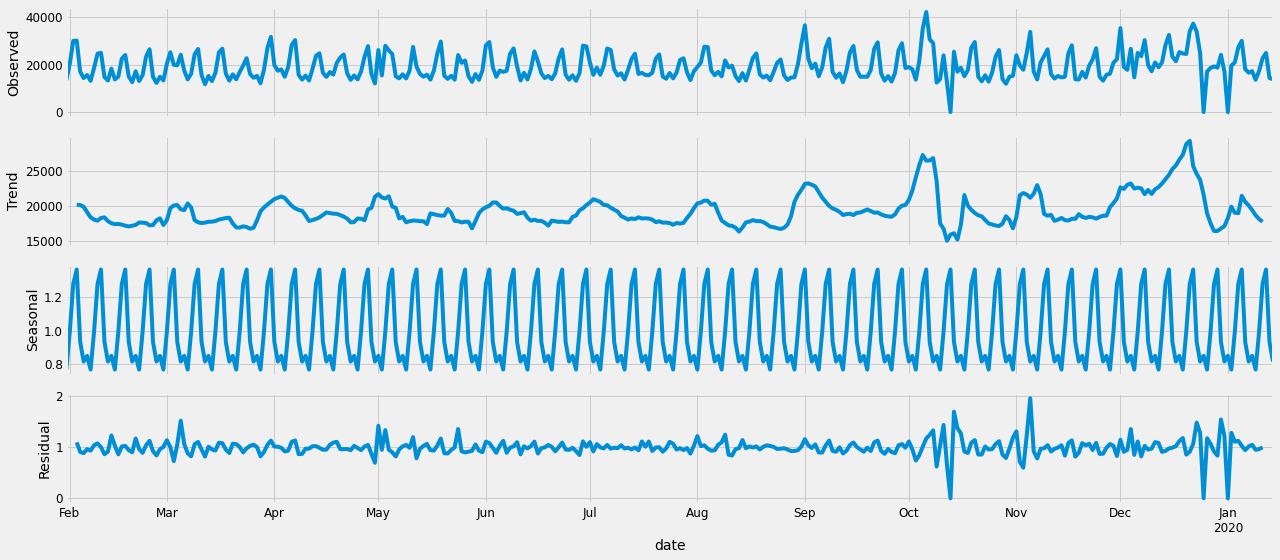

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

### Rolling Statistics

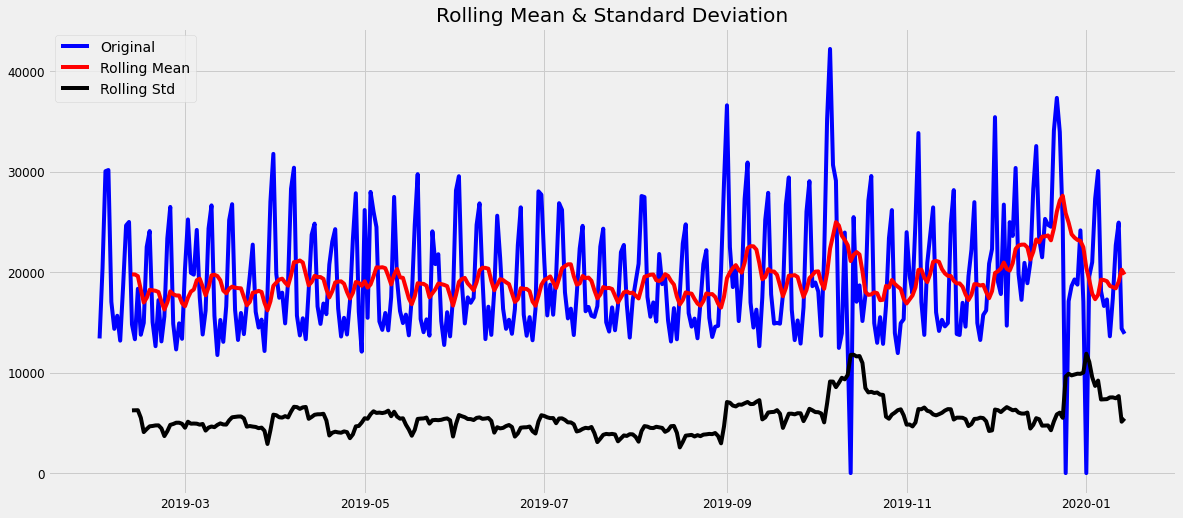

In [ ]:
#Determing rolling statistics
rolmean = pd.Series.rolling(y, window=12).mean()
rolstd = pd.Series.rolling(y, window=12).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Prueba de Dickey-Fuller

**Prueba aumentada de Dickey-Fuller** La intuición detrás de la prueba es que si la serie está integrada, entonces el nivel rezagado de la serie y (t-1) no proporcionará información relevante para predecir el cambio en y (t). Hipótesis nula: la serie temporal no es estacionaria Rechazar la hipótesis nula (es decir, un valor p muy bajo) indicará estacionariedad

In [ ]:
from statsmodels.tsa.stattools import adfuller
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.649890
p-value                          0.004876
#Lags Used                      13.000000
Number of Observations Used    335.000000
Critical Value (1%)             -3.450022
Critical Value (5%)             -2.870207
Critical Value (10%)            -2.571387
dtype: float64


Al tener un p-value=0.004 se rechaza la hipotesis nula, y se puede concluir que la serie es estacionaria.

### Entrenando el modelo

In [150]:
from statsmodels.tsa.ar_model import AR
from random import random

In [151]:
# fit model: Modelo AR autorregresivo
model1 = AR(y)
model1_fit = model1.fit()

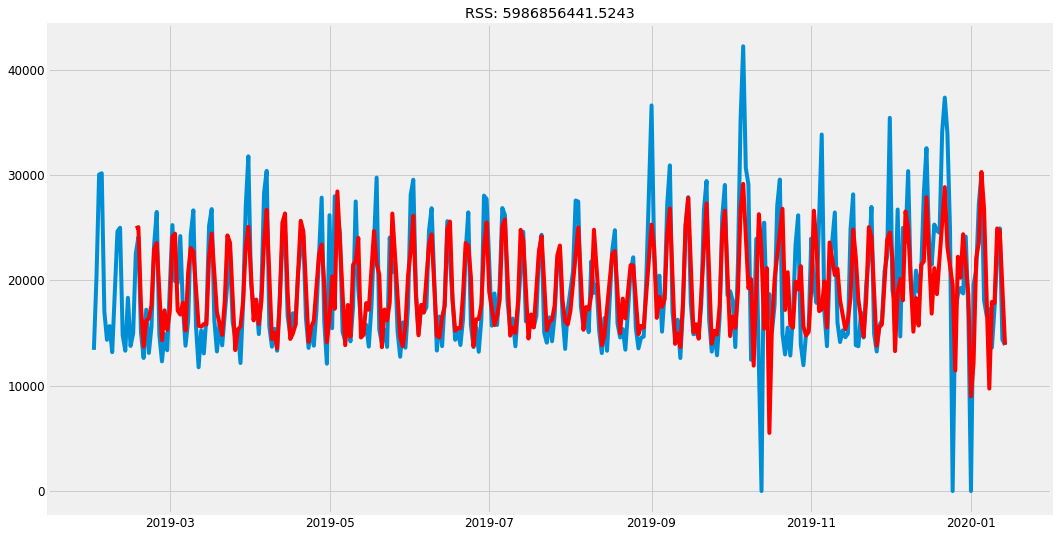

In [152]:
plt.plot(y)
plt.plot(model1_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model1_fit.fittedvalues-y)**2))
plt.show()

### Predicción en el TRAIN

In [ ]:
predictions_ARIMA_diff = pd.Series(model1_fit.fittedvalues, index=y.index, copy=True)

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [ ]:
predictions_ARIMA_log = pd.Series(y, index=y.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2019-01-31    13401.0
2019-02-01    20371.0
2019-02-02    30048.0
2019-02-03    30165.0
2019-02-04    17045.0
Freq: D, dtype: float64

In [ ]:
predictions_ARIMA = predictions_ARIMA_log

Text(0.5, 1.0, 'RMSE: 4141.7770')

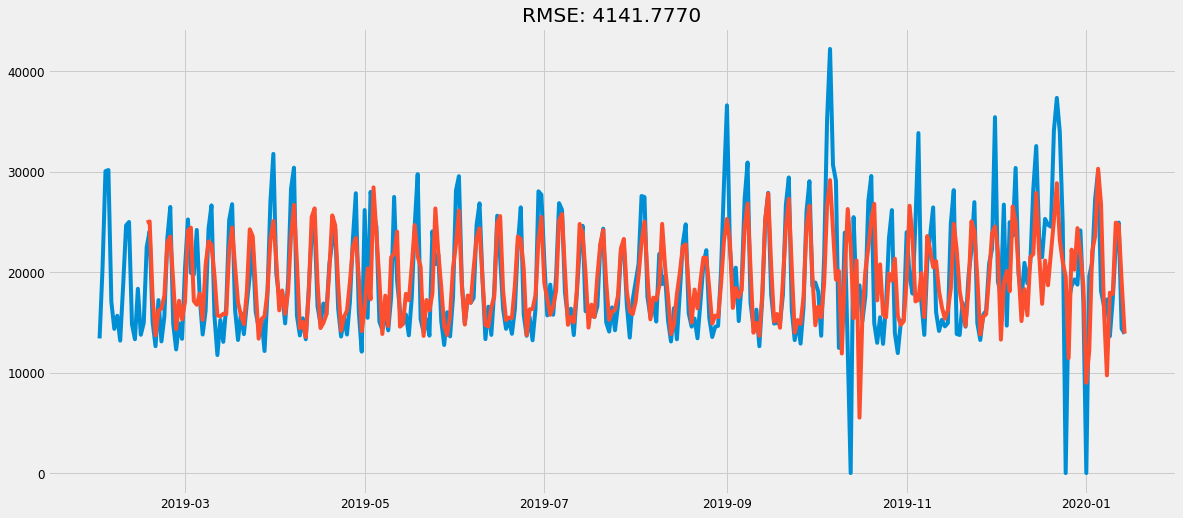

In [ ]:
plt.plot(y)
plt.plot(predictions_ARIMA_diff)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum( (predictions_ARIMA_diff-y) **2) /len(y) ) )

In [ ]:
model1_fit.save("modelo1.h5")

Con este modelo SARIMA se obtiene un **RMSE=4041.77** en el conjunto del train

### Predicción en el TEST

In [161]:
# Predicción
import datetime

d = datetime.date(2020, 1, 15)
d2 = datetime.date(2020, 1, 31)

pred1 = model1_fit.predict(start= d, end=d2)
pred1

2020-01-15    11640.525470
2020-01-16    14307.132699
2020-01-17    20884.442449
2020-01-18    23990.975753
2020-01-19    24945.178657
2020-01-20    19724.290647
2020-01-21    16529.633184
2020-01-22    15239.630877
2020-01-23    16252.759933
2020-01-24    20544.808583
2020-01-25    23807.147835
2020-01-26    24120.544410
2020-01-27    18847.050029
2020-01-28    15193.616275
2020-01-29    14524.934706
2020-01-30    16035.057170
2020-01-31    20295.731293
Freq: D, dtype: float64

In [160]:
# Real: desde 2020-01-15 hasta 2020-01-31
test1 = test_split.set_index("date")["unit_sales"].resample("D").sum()
test1

date
2020-01-15    14768.0
2020-01-16    13734.0
2020-01-17    17617.0
2020-01-18    22513.0
2020-01-19    25802.0
2020-01-20    14419.0
2020-01-21    12198.0
2020-01-22    14729.0
2020-01-23    13054.0
2020-01-24    15610.0
2020-01-25    23025.0
2020-01-26    23754.0
2020-01-27    14026.0
2020-01-28    12466.0
2020-01-29    14256.0
2020-01-30    13246.0
2020-01-31    17241.0
Freq: D, Name: unit_sales, dtype: float64

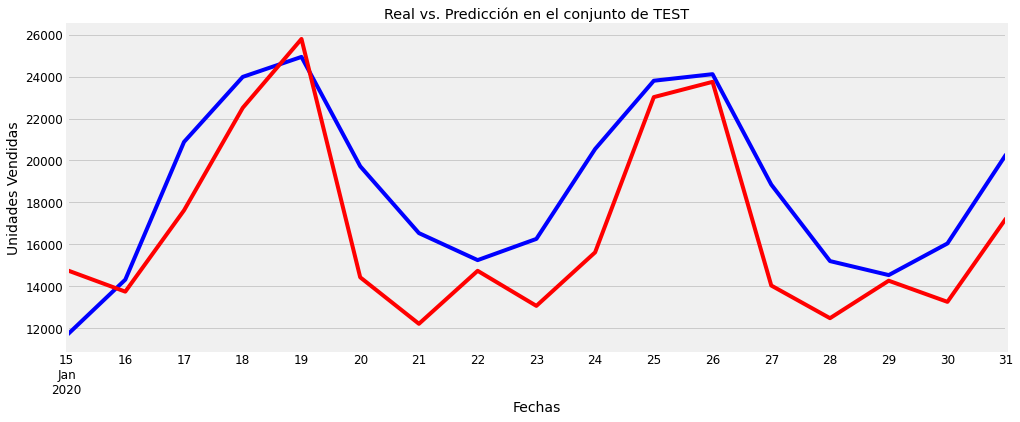

In [162]:
# plot de la serie temporal real y predicción
pred1.plot(figsize=(15, 6), color='b')
test1.plot(figsize=(15, 6), color='r')
plt.title("Real vs. Predicción en el conjunto de TEST")
plt.ylabel('Unidades Vendidas')
plt.xlabel('Fechas')  
plt.show()

In [163]:
# Uniendo los dos, lo real vs. la predicción para calcular el RMSE
pred1 = pred1.to_frame()
test1 = test1.to_frame()
total = pd.concat([pred1, test1], axis=1,)
total.rename(columns={0: 'pred_unit_sales'}, inplace=True)
total.columns.values

array(['pred_unit_sales', 'unit_sales'], dtype=object)

In [164]:
total['error'] = (total['pred_unit_sales'] - total['unit_sales'])**2
RMSE = math.sqrt(total['error'].mean())
print("RMSE en el conjunto de TEST es: ", RMSE)

RMSE en el conjunto de TEST es:  3010.4688512406497


## **ARMA Autoregressive Moving Average**

### Entrenando el modelo

In [165]:
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model2 = ARMA(y, order=(3, 2))
model2_fit = model2.fit(disp=False)

In [166]:
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             unit_sales   No. Observations:                  349
Model:                     ARMA(3, 2)   Log Likelihood               -3421.860
Method:                       css-mle   S.D. of innovations           4326.066
Date:                Thu, 02 Jul 2020   AIC                           6857.720
Time:                        16:55:02   BIC                           6884.705
Sample:                    01-31-2019   HQIC                          6868.462
                         - 01-14-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.927e+04    301.026     63.999      0.000    1.87e+04    1.99e+04
ar.L1.unit_sales     1.4752      0.000   8293.687      0.000       1.475       1.476
ar.L2.unit_sales    -1.2833        nan        nan        nan         nan         nan
ar.L3.unit_sales     0.2270   7.53e-05   3014.931      0.000       0.227       0.227
ma.L1.unit_sales    -1.2440      0.015    -84.711      0.000      -1.273      -1.215
ma.L2.unit_sales     1.0000      0.012     86.351      0.000       0.977       1.023
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6241           -0.7813j            1.0000           -0.1427
AR.2            0.6241           +0.7813j            1.0000            0.1427
AR.3            4.4049           -0.0000j            4.4049           -0.0000
MA.1            0.6220           -0.7830j            1.0000           -0.1432
MA.2            0.6220           +0.7830j            1.0000            0.1432
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 6685908322.9947')

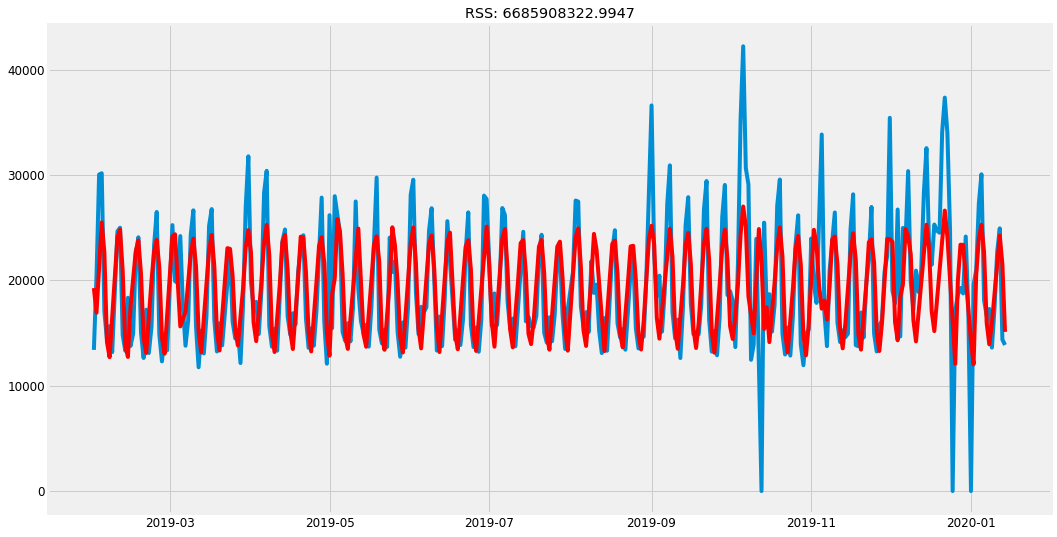

In [167]:
plt.plot(y)
plt.plot(model2_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model2_fit.fittedvalues-y)**2))

### Predicción en el TRAIN

In [171]:
predictions_AR_diff = pd.Series(model2_fit.fittedvalues, index=y.index, copy=True)

In [172]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()

In [173]:
predictions_AR_log = pd.Series(y, index=y.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR_log.head()

date
2019-01-31     32666.437600
2019-02-01     56563.915847
2019-02-02     87591.483606
2019-02-03    113207.264646
2019-02-04    122754.260364
Freq: D, dtype: float64

In [174]:
predictions_AR = predictions_AR_log

Text(0.5, 1.0, 'RMSE: 4376.9088')

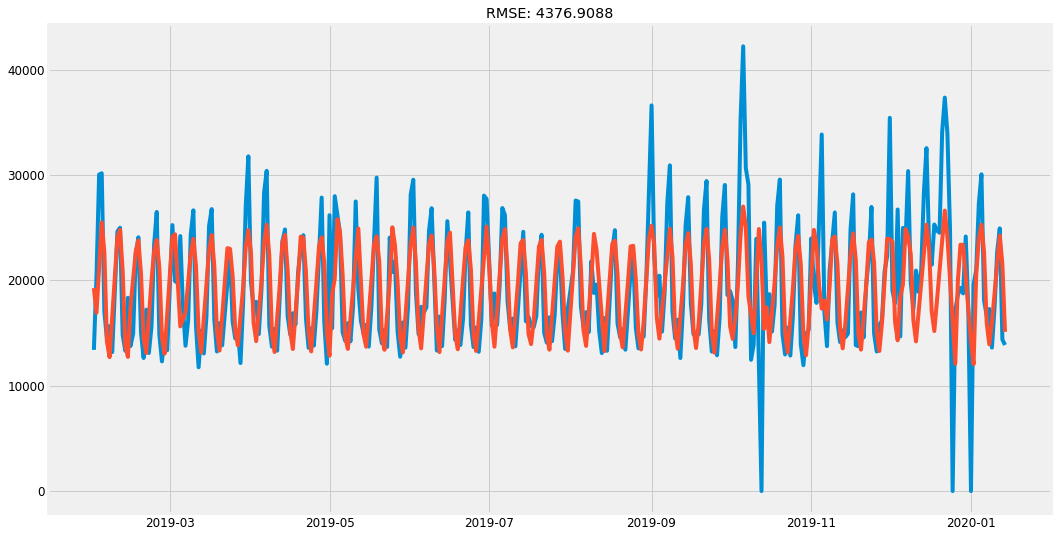

In [175]:
plt.plot(y)
plt.plot(predictions_AR_diff)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_AR_diff-y)**2)/len(y)))

Con este modelo SARIMA se obtiene un **RMSE=4376.90**

In [ ]:
# Guardando el modelo

model2_fit.save("modelo2.h5")

### Predicción en el TEST

In [176]:
# Predicción
import datetime

d = datetime.date(2020, 1, 15)
d2 = datetime.date(2020, 1, 31)

pred2 = model2_fit.predict(start= d, end=d2)
pred2

2020-01-15    13258.631798
2020-01-16    14979.144280
2020-01-17    19425.418161
2020-01-18    23638.610254
2020-01-19    24538.544351
2020-01-20    21468.547509
2020-01-21    16741.102346
2020-01-22    13911.163675
2020-01-23    15106.344988
2020-01-24    19428.112357
2020-01-25    23627.477463
2020-01-26    24547.539869
2020-01-27    21496.716923
2020-01-28    16768.587267
2020-01-29    13917.601477
2020-01-30    15086.964485
2020-01-31    19397.499063
Freq: D, dtype: float64

In [177]:
# Real: desde 2020-01-15 hasta 2020-01-31
test2 = test_split.set_index("date")["unit_sales"].resample("D").sum()
test2

date
2020-01-15    14768.0
2020-01-16    13734.0
2020-01-17    17617.0
2020-01-18    22513.0
2020-01-19    25802.0
2020-01-20    14419.0
2020-01-21    12198.0
2020-01-22    14729.0
2020-01-23    13054.0
2020-01-24    15610.0
2020-01-25    23025.0
2020-01-26    23754.0
2020-01-27    14026.0
2020-01-28    12466.0
2020-01-29    14256.0
2020-01-30    13246.0
2020-01-31    17241.0
Freq: D, Name: unit_sales, dtype: float64

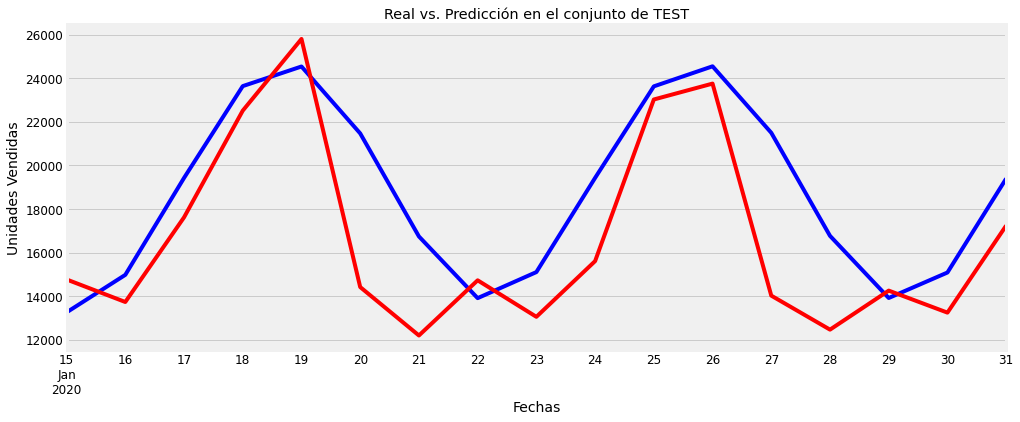

In [179]:
# plot de la serie temporal real y predicción
pred2.plot(figsize=(15, 6), color='b')
test2.plot(figsize=(15, 6), color='r')
plt.title("Real vs. Predicción en el conjunto de TEST")
plt.ylabel('Unidades Vendidas')
plt.xlabel('Fechas')  
plt.show()

In [180]:
# Uniendo los dos, lo real vs. la predicción para calcular el RMSE
pred2 = pred2.to_frame()
test2 = test2.to_frame()
total2 = pd.concat([pred2, test2], axis=1,)

# Renombrando a las columnas
total2.rename(columns={0: 'pred_unit_sales'}, inplace=True)
total2.columns.values

array(['pred_unit_sales', 'unit_sales'], dtype=object)

In [181]:
total2['error'] = (total2['pred_unit_sales'] - total2['unit_sales'])**2
RMSE = math.sqrt(total2['error'].mean())
print("RMSE en el conjunto de test es: ", RMSE)

RMSE en el conjunto de test es:  3283.0028744011224


## **Redes Neuronales**

In [198]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
 
# fix random seed for reproducibility
numpy.random.seed(7)

In [199]:
# Seleccionando solo las columnas a usar
# Train
trainv2 = train_split[['date', 'item_nbr', 'clasificacion', 'subclasificacion', 'unit_sales', 'onpromotion', 'precio']]
trainv2.head()

,date,item_nbr,clasificacion,subclasificacion,unit_sales,onpromotion,precio
0,2020-01-07,7861001236101,1066-MOSTAZAS,0020-BASICA,20.0,False,0.57
1,2019-07-10,7861001238013,1022-CALDOS,0030-POLVO,11.0,False,1.19
2,2019-09-25,7861001299205,1022-CALDOS,0010-CUBO,25.0,False,2.16
3,2019-06-22,7861002386997,1022-CALDOS,0030-POLVO,18.0,True,1.79
4,2019-03-30,7861001231991,1022-CALDOS,0030-POLVO,1.0,False,7.94


In [200]:
# Test
testv2 = test_split[['date', 'item_nbr', 'clasificacion', 'subclasificacion', 'unit_sales', 'onpromotion', 'precio']]
testv2.head()

,date,item_nbr,clasificacion,subclasificacion,unit_sales,onpromotion,precio
31,2020-01-27,7861001267761,1066-MOSTAZAS,0020-BASICA,4.0,True,0.93
75,2020-01-25,7861001291902,1022-CALDOS,0010-CUBO,11.0,False,1.43
110,2020-01-23,7861001299205,1022-CALDOS,0010-CUBO,49.0,True,2.16
143,2020-01-23,7501058622501,1009-(I) ALIMENTOS INFANTILES,0061-(I) LECHES SEGUNDA ETAPA,1.0,False,16.21
202,2020-01-16,840101676960,1083-(I) ALGODONES Y SIMILARES,0031-(I) COTONETES ASEO,1.0,False,1.50


In [201]:
# Convirtiendo a variables dummies
#trainv2 = pd.get_dummies(trainv2, columns=['clasificacion'])
#trainv2 = pd.get_dummies(trainv2, columns=['subclasificacion'])
#trainv2 = pd.get_dummies(trainv2, columns=['onpromotion'] ,drop_first=True)
#trainv2.head()

In [202]:
y_train = trainv2.set_index("date")["unit_sales"].resample("D").sum()
df_train=y_train.to_frame()
dataset_train = df_train.values
dataset_train = dataset_train.astype('float32')

In [203]:
y_test = testv2.set_index("date")["unit_sales"].resample("D").sum()
df_test=y_test.to_frame()
dataset_test = df_test.values
dataset_test = dataset_test.astype('float32')

In [204]:
#y_train, y_test
#dataset_train, dataset_test

In [205]:
# reshape dataset
look_back = 3
trainX, trainY = create_dataset(dataset_train, look_back)
testX, testY = create_dataset(dataset_test, look_back)

In [206]:
# create and fit Multilayer Perceptron model
model3 = Sequential()
model3.add(Dense(12, input_dim=look_back, activation='relu'))
model3.add(Dense(8, activation='relu'))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)

Epoch 1/400
 - 0s - loss: 252210446.5384
Epoch 2/400
 - 0s - loss: 56340385.5632
Epoch 3/400
 - 0s - loss: 47448159.7879
Epoch 4/400
 - 0s - loss: 45618416.0576
Epoch 5/400
 - 0s - loss: 43956484.2279
Epoch 6/400
 - 0s - loss: 42809678.7201
Epoch 7/400
 - 0s - loss: 41723625.7620
Epoch 8/400
 - 0s - loss: 40910611.9364
Epoch 9/400
 - 0s - loss: 39223251.0486
Epoch 10/400
 - 0s - loss: 37851966.1826
Epoch 11/400
 - 0s - loss: 37418197.0412
Epoch 12/400
 - 0s - loss: 37027103.3408
Epoch 13/400
 - 0s - loss: 36346784.1118
Epoch 14/400
 - 0s - loss: 35944257.3603
Epoch 15/400
 - 0s - loss: 36289867.7067
Epoch 16/400
 - 0s - loss: 36592869.4293
Epoch 17/400
 - 0s - loss: 35967697.9297
Epoch 18/400
 - 0s - loss: 35761532.8771
Epoch 19/400
 - 0s - loss: 35894794.2999
Epoch 20/400
 - 0s - loss: 35367301.8587
Epoch 21/400
 - 0s - loss: 35382357.5347
Epoch 22/400
 - 0s - loss: 35335278.5475
Epoch 23/400
 - 0s - loss: 35199051.2254
Epoch 24/400
 - 0s - loss: 35229843.4444
Epoch 25/400
 - 0s - los

### Evaluación del Modelo

In [207]:
# Evaluando el modelo en el TRAIN
trainScore = model3.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))


Train Score: 31345051.93 MSE (5598.67 RMSE)


In [208]:
# Evaluando el modelo en el TEST
testScore = model3.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 18306024.00 MSE (4278.55 RMSE)


- Con redes neuronales se obtuvo un **RMSE=5598.67** en el conjunto de train.
- Con redes neuronales se obtuvo un **RMSE=4278.55** en el conjunto de test.

### Predicción en el TRAIN

In [209]:
# Generando predicciones para el train
trainPredict = model3.predict(trainX)

In [210]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset_train)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

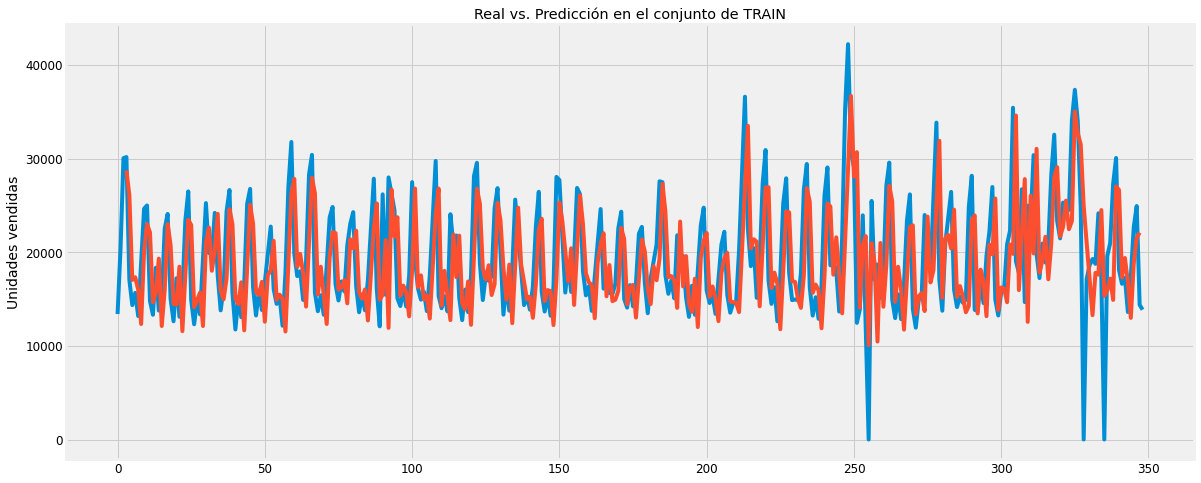

In [212]:
# plot baseline and predictions
rcParams['figure.figsize'] = 18, 8
plt.plot(dataset_train)
plt.plot(trainPredictPlot)
plt.title("Real vs. Predicción en el conjunto de TRAIN")
plt.ylabel('Unidades vendidas')
#plt.plot(testPredictPlot)
plt.show()

### Predicción en el TEST

In [213]:
# Generando predicciones en el test
testPredict = model3.predict(testX)

In [214]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset_test)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[look_back:len(testPredict)+look_back, :] = testPredict

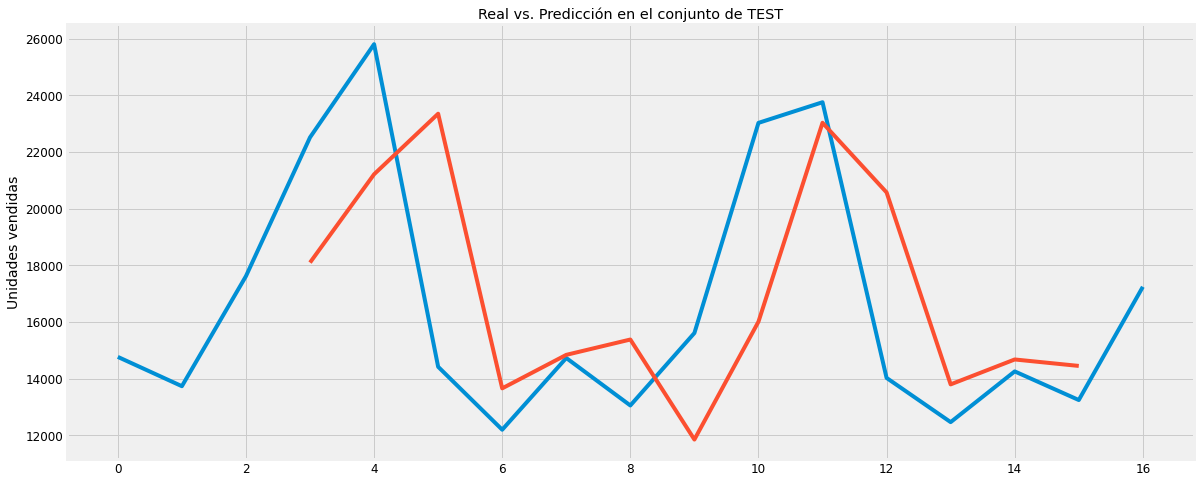

In [216]:
# plot baseline and predictions
plt.plot(dataset_test)
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("Real vs. Predicción en el conjunto de TEST")
plt.ylabel('Unidades vendidas')
plt.show()

In [ ]:
model3.save("modelo3.h5")

# **Problema Supervisado**

- Se convierte la serie temporal en un “problema de tipo supervisado“ para poder alimentar la red neuronal y poder entrenarla con backpropagation.

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

In [218]:
y2 = train_split.set_index("date")["unit_sales"].resample("D").sum()
df2 = y2.to_frame()
df2

,unit_sales
date,
2019-01-31,13401.0
2019-02-01,20371.0
2019-02-02,30048.0
2019-02-03,30165.0
2019-02-04,17045.0
...,...
2020-01-10,17384.0
2020-01-11,22676.0
2020-01-12,24934.0


### Añadiendo nuevas variables

In [219]:

df2['weekday']=[x.weekday() for x in df2.index]
df2['month']=[x.month for x in df2.index]
df2.head()

,unit_sales,weekday,month
date,,,
2019-01-31,13401.0,3,1
2019-02-01,20371.0,4,2
2019-02-02,30048.0,5,2
2019-02-03,30165.0,6,2
2019-02-04,17045.0,0,2


In [220]:
df2.describe()

,unit_sales,weekday,month
count,349.000000,349.000000,349.00000
mean,19265.438395,3.002865,6.77937
std,5873.927984,2.005020,3.31663
min,1.000000,0.000000,1.00000
25%,15031.000000,1.000000,4.00000
50%,17459.000000,3.000000,7.00000
75%,23605.000000,5.000000,10.00000
max,42215.000000,6.000000,12.00000


### Procesado de los datos

Lo que haremos es tomar los 7 días previos para obtener el octavo. 

- Input: serán “7 columnas” que representan las ventas en unidades de los 7 días anteriores.
- Output: El valor del “8vo día”. Es decir, las ventas en unidades de ese día.

In [221]:

PASOS=7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [222]:
# Cargando el dataset de train
values = df2['unit_sales'].values

# Convirtiendo a tipo de dato float
values = values.astype('float32')

# Escalando los datos
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

# Aplicando la función previa para convertir una serie en un problema supervisado
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df2['weekday']
reframed['month']=df2['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df2['weekday'][i+8]
    reframed['month'].loc[contador]=df2['month'][i+8]
    contador=contador+1
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month
0,-0.365139,-0.034917,0.423556,0.429099,-0.192495,-0.319846,-0.258161,-0.375420,4.0,2.0
1,-0.034917,0.423556,0.429099,-0.192495,-0.319846,-0.258161,-0.375420,-0.116644,5.0,2.0
2,0.423556,0.429099,-0.192495,-0.319846,-0.258161,-0.375420,-0.116644,0.167859,6.0,2.0
3,0.429099,-0.192495,-0.319846,-0.258161,-0.375420,-0.116644,0.167859,0.184157,0.0,2.0
4,-0.192495,-0.319846,-0.258161,-0.375420,-0.116644,0.167859,0.184157,-0.299142,1.0,2.0


In [223]:
reframed.shape

(342, 10)

In [224]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado

,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,4.0,2.0,-0.365139,-0.034917,0.423556,0.429099,-0.192495,-0.319846,-0.258161,-0.375420
1,5.0,2.0,-0.034917,0.423556,0.429099,-0.192495,-0.319846,-0.258161,-0.375420,-0.116644
2,6.0,2.0,0.423556,0.429099,-0.192495,-0.319846,-0.258161,-0.375420,-0.116644,0.167859
3,0.0,2.0,0.429099,-0.192495,-0.319846,-0.258161,-0.375420,-0.116644,0.167859,0.184157
4,1.0,2.0,-0.192495,-0.319846,-0.258161,-0.375420,-0.116644,0.167859,0.184157,-0.299142
...,...,...,...,...,...,...,...,...,...,...
336,4.0,1.0,-0.071919,-0.005875,0.293031,0.424409,-0.142038,-0.212062,-0.181219,-0.354906
337,5.0,1.0,-0.005875,0.293031,0.424409,-0.142038,-0.212062,-0.181219,-0.354906,-0.176434
338,6.0,1.0,0.293031,0.424409,-0.142038,-0.212062,-0.181219,-0.354906,-0.176434,0.074288
339,0.0,1.0,0.424409,-0.142038,-0.212062,-0.181219,-0.354906,-0.176434,0.074288,0.181267


### Dividiendo en conjunto de TRAIN y VALIDATION

In [225]:
# Dividimos en conjunto de entrenamiento y validación
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[340-30:340]
valid_target=target_data[340-30:340]

training_data = training_data[0:340]
target_data=target_data[0:340]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(340, 9) (340,) (30, 9) (30,)


### Creación del Modelo de Redes Neuronales

In [226]:
# Creamos el Modelo de Red Neuronal

def crear_modeloEmbeddings():
    emb_dias = 2 
    emb_meses = 4

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

In [228]:
EPOCHS=400

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dias (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
meses (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 2)         16          dias[0][0]                       
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 4)         52          meses[0][0]                      
____________________________________________________________________________________________

### Visualización de Resultados

In [259]:
# Train
results_train=model.predict([training_data['weekday'],training_data['month'],continuas])

In [260]:
compara_train = pd.DataFrame(np.array([target_data, [x[0] for x in results_train]])).transpose()
compara_train.columns = ['real', 'prediccion']

inverted_train = scaler.inverse_transform(compara_train.values)

compara_train2 = pd.DataFrame(inverted_train)
compara_train2.columns = ['real', 'prediccion']
compara_train2['error'] = (compara_train2['real'] - compara_train2['prediccion'])**2
compara_train2.head()

,real,prediccion,error
0,16446.390625,16445.753906,0.405411
1,18206.589844,17601.345703,366320.468750
2,20141.777344,19750.853516,152821.437500
3,20252.636719,20334.673828,6730.087402
4,16965.234375,17090.544922,15702.733398


Text(0.5, 1.0, 'Real vs. Predicción en el conjunto de TRAIN')

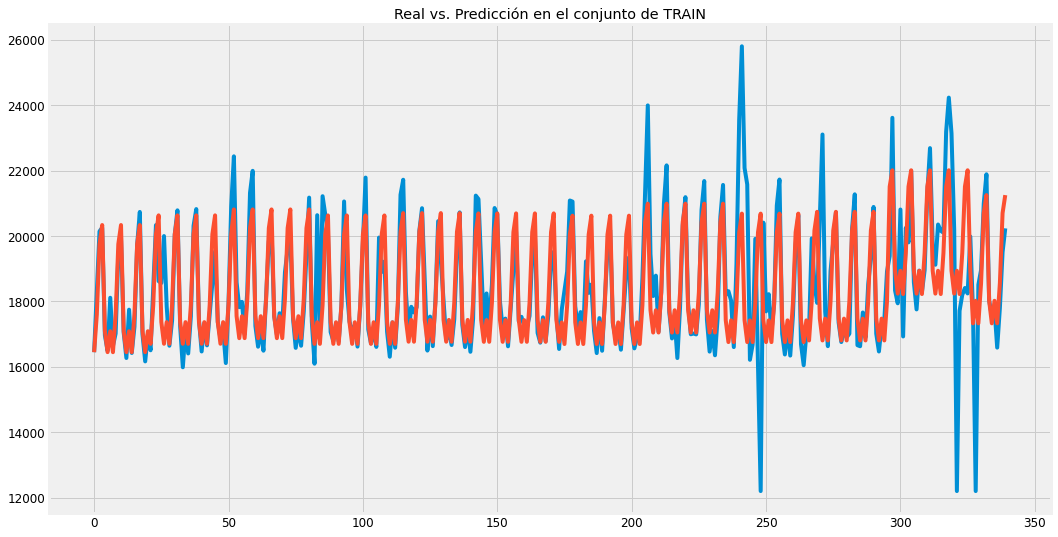

In [268]:
# Graficando 
compara_train2['real'].plot()
compara_train2['prediccion'].plot()
plt.title("Real vs. Predicción en el conjunto de TRAIN")

In [262]:
# Cálculo del RMSE
RMSE = math.sqrt(compara_train2['error'].mean())
print("El RMSE en el conjunto de TRAIN es de:", RMSE)

El RMSE en el conjunto de TRAIN es de: 1291.3108165736087


30


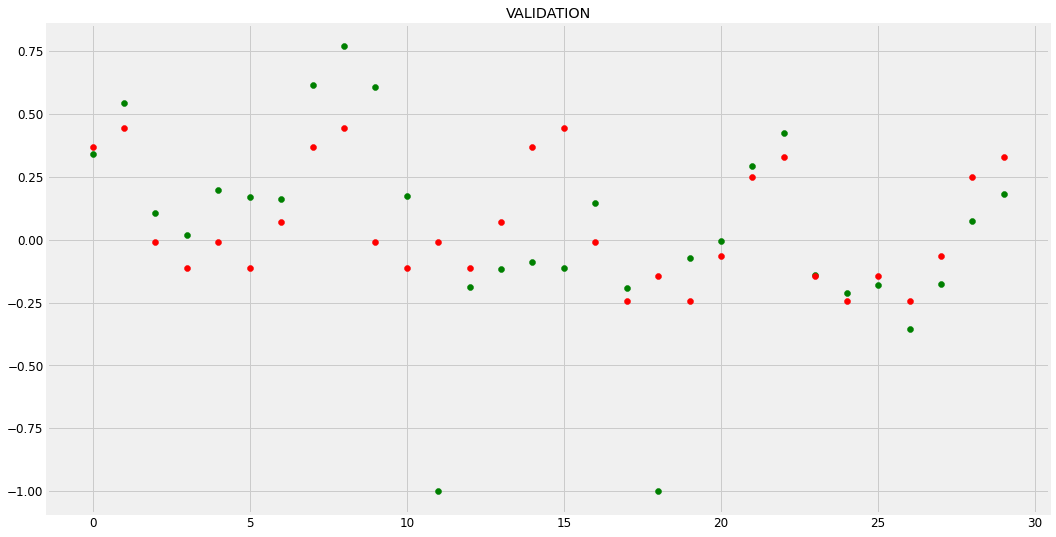

In [264]:
# Validation
results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('VALIDATION')
plt.show()
# Visualizamos al conjunto de validación (30 días)

- En la gráfica vemos que los puntos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. 
- Si aumentamos la cantidad de EPOCHS mejora cada vez más.

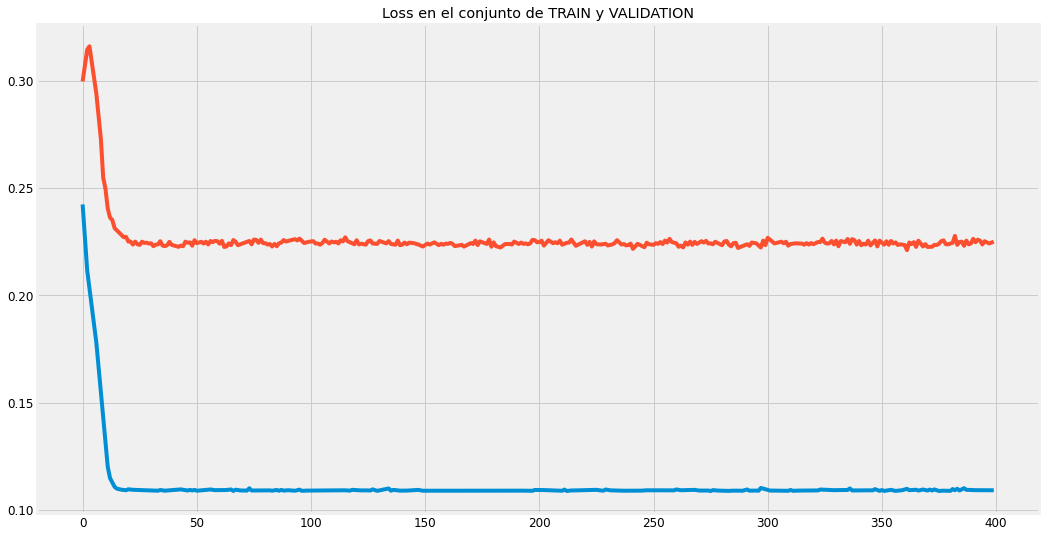

In [265]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('Loss en el conjunto de TRAIN y VALIDATION')
plt.show()

- Podemos observar que la pérdida es distinta en ambos casos. 
- Por tanto al parecer no hay overfitting, pues las curvas de train y validate son distintas.

In [266]:
compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['error'] = (compara2['real'] - compara2['prediccion'])**2
compara2.head()

,real,prediccion,error
0,21309.335938,21511.367188,4.081662e+04
1,22687.654297,22009.671875,4.596602e+05
2,19719.935547,18937.125000,6.127924e+05
3,19120.203125,18237.251953,7.796028e+05
4,20351.248047,18935.541016,2.004226e+06


Text(0.5, 1.0, 'Real vs. Predicción en el conjunto de VALIDATION')

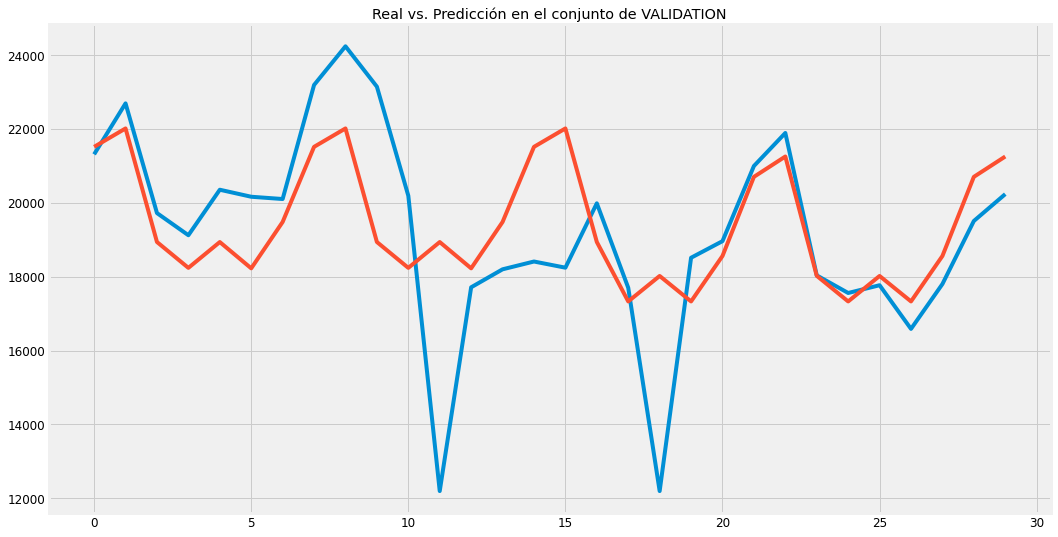

In [269]:
compara2['real'].plot()
compara2['prediccion'].plot()
plt.title("Real vs. Predicción en el conjunto de VALIDATION")

In [267]:
# Cálculo del RMSE
RMSE = math.sqrt(compara2['error'].mean())
print("El RMSE en el conjunto de VALIDATION es de:", RMSE)

El RMSE en el conjunto de VALIDATION es de: 2230.251443223387


### Predicción en el conjunto de TEST

In [236]:

y3 = test_split.set_index("date")["unit_sales"].resample("D").sum()
df3 = y3.to_frame()
df3

,unit_sales
date,
2020-01-15,14768.0
2020-01-16,13734.0
2020-01-17,17617.0
2020-01-18,22513.0
2020-01-19,25802.0
2020-01-20,14419.0
2020-01-21,12198.0
2020-01-22,14729.0
2020-01-23,13054.0


In [237]:
df3['weekday']=[x.weekday() for x in df3.index]
df3['month']=[x.month for x in df3.index]
df3.head()

,unit_sales,weekday,month
date,,,
2020-01-15,14768.0,2,1
2020-01-16,13734.0,3,1
2020-01-17,17617.0,4,1
2020-01-18,22513.0,5,1
2020-01-19,25802.0,6,1


In [238]:
# preparamos los datos para hacer el test
# load dataset
values = df3['unit_sales'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df3['weekday']
reframed['month']=df3['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df3['weekday'][i+8]
    reframed['month'].loc[contador]=df3['month'][i+8]
    contador=contador+1
reframed.head()

reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)'] ]
reordenado.dropna(inplace=True)
reordenado

,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
0,3.0,1.0,-0.622170,-0.774184,-0.203323,0.516466,1.000000,-0.673478,-1.000000
1,4.0,1.0,-0.774184,-0.203323,0.516466,1.000000,-0.673478,-1.000000,-0.627903
2,5.0,1.0,-0.203323,0.516466,1.000000,-0.673478,-1.000000,-0.627903,-0.874155
3,6.0,1.0,0.516466,1.000000,-0.673478,-1.000000,-0.627903,-0.874155,-0.498383
4,0.0,1.0,1.000000,-0.673478,-1.000000,-0.627903,-0.874155,-0.498383,0.591738
5,1.0,1.0,-0.673478,-1.000000,-0.627903,-0.874155,-0.498383,0.591738,0.698912
6,2.0,1.0,-1.000000,-0.627903,-0.874155,-0.498383,0.591738,0.698912,-0.731256
7,3.0,1.0,-0.627903,-0.874155,-0.498383,0.591738,0.698912,-0.731256,-0.960600
8,4.0,1.0,-0.874155,-0.498383,0.591738,0.698912,-0.731256,-0.960600,-0.697442


In [239]:
values = reordenado.values
x_test = values[5:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = reordenado.weekday[len(reordenado.index)-1]
ultDiaSemana

(4, 1, 9)
[[[ 1.          1.         -0.67347836 -1.         -0.62790346
   -0.87415469 -0.49838281  0.59173775  0.69891214]]

 [[ 2.          1.         -1.         -0.62790346 -0.87415469
   -0.49838281  0.59173775  0.69891214 -0.73125553]]

 [[ 3.          1.         -0.62790346 -0.87415469 -0.49838281
    0.59173775  0.69891214 -0.73125553 -0.96059978]]

 [[ 4.          1.         -0.87415469 -0.49838281  0.59173775
    0.69891214 -0.73125553 -0.96059978 -0.69744182]]]


4.0

In [240]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i+2] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][0]=ultDiaSemana
    x_test[0][0][1]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [271]:
# Pronóstico para los proximos 16 días
results=[]
for i in range(17):
    dia=np.array([x_test[0][0][0]])
    mes=np.array([x_test[0][0][1]])
    valores=np.array([x_test[0][0][2:19]]) #antes estaba valores=np.array([x_test[0][0][2:9]])
    parcial=model.predict([dia, mes, valores])
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 4.00000000e+00  1.20000000e+01 -1.43712550e-01  7.04248324e-02
    3.69210273e-01  4.42468643e-01 -9.24359541e-03 -1.12135842e-01
   -9.47644282e-03]]

 [[ 2.00000000e+00  1.00000000e+00 -1.00000000e+00 -6.27903461e-01
   -8.74154687e-01 -4.98382807e-01  5.91737747e-01  6.98912144e-01
   -7.31255531e-01]]

 [[ 3.00000000e+00  1.00000000e+00 -6.27903461e-01 -8.74154687e-01
   -4.98382807e-01  5.91737747e-01  6.98912144e-01 -7.31255531e-01
   -9.60599780e-01]]

 [[ 4.00000000e+00  1.00000000e+00 -8.74154687e-01 -4.98382807e-01
    5.91737747e-01  6.98912144e-01 -7.31255531e-01 -9.60599780e-01
   -6.97441816e-01]]]
pred 1 [[[ 5.00000000e+00  1.20000000e+01  7.04248324e-02  3.69210273e-01
    4.42468643e-01 -9.24359541e-03 -1.12135842e-01 -9.47644282e-03
   -1.13979429e-01]]

 [[ 2.00000000e+00  1.00000000e+00 -1.00000000e+00 -6.27903461e-01
   -8.74154687e-01 -4.98382807e-01  5.91737747e-01  6.98912144e-01
   -7.31255531e-01]]

 [[ 3.00000000e+00  1.00000000e+00 -6.27903461e-01

In [272]:
# Re-Convertimos los resultados
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.11397943], dtype=float32), array([0.07042483], dtype=float32), array([0.36921027], dtype=float32), array([0.44246864], dtype=float32), array([-0.0092436], dtype=float32), array([-0.11213584], dtype=float32), array([-0.00947644], dtype=float32), array([-0.11397943], dtype=float32), array([0.07042483], dtype=float32), array([0.36921027], dtype=float32), array([0.44246864], dtype=float32), array([-0.0092436], dtype=float32), array([-0.11213584], dtype=float32), array([-0.00947644], dtype=float32), array([-0.11397943], dtype=float32), array([0.07042483], dtype=float32), array([0.36921027], dtype=float32)]


array([[18224.71195231],
       [19479.02973601],
       [21511.36829923],
       [22009.67173211],
       [18937.12509104],
       [18237.25202809],
       [18935.54126298],
       [18224.71195231],
       [19479.02973601],
       [21511.36829923],
       [22009.67173211],
       [18937.12509104],
       [18237.25202809],
       [18935.54126298],
       [18224.71195231],
       [19479.02973601],
       [21511.36829923]])

In [273]:
# Visualizamos el pronostico
prediccion2SemanaEne = pd.DataFrame(inverted)
prediccion2SemanaEne
prediccion2SemanaEne.columns = ['pronostico']

In [274]:
real = y3.to_frame() #y3[0:7].to_frame()
real = real.reset_index()

In [275]:
comparacion = pd.concat([real, prediccion2SemanaEne], axis=1)
comparacion

,date,unit_sales,pronostico
0,2020-01-15,14768.0,18224.711952
1,2020-01-16,13734.0,19479.029736
2,2020-01-17,17617.0,21511.368299
3,2020-01-18,22513.0,22009.671732
4,2020-01-19,25802.0,18937.125091
5,2020-01-20,14419.0,18237.252028
6,2020-01-21,12198.0,18935.541263
7,2020-01-22,14729.0,18224.711952
8,2020-01-23,13054.0,19479.029736
9,2020-01-24,15610.0,21511.368299


Text(0, 0.5, 'Unidades Vendidas')

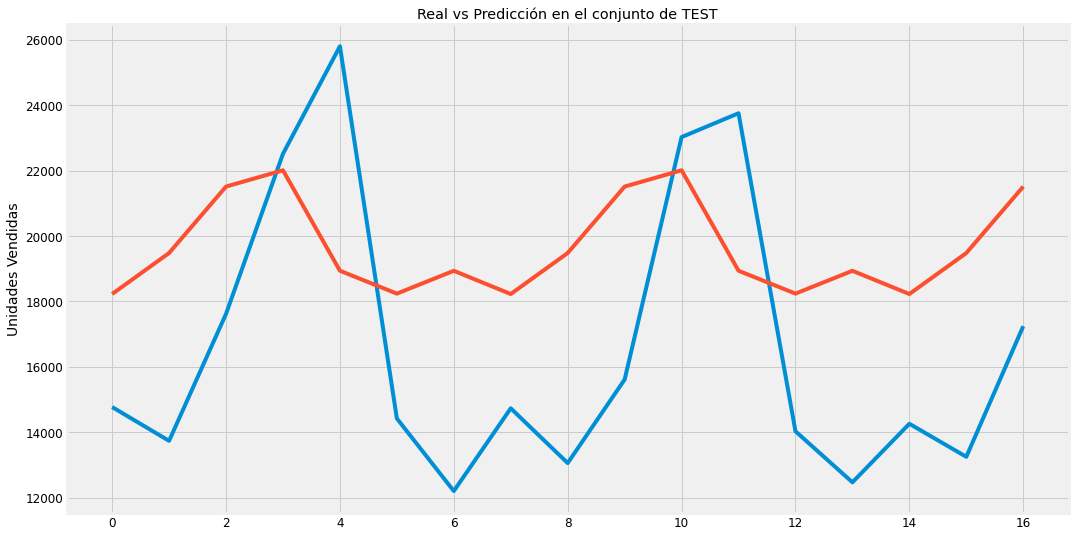

In [277]:
plt.plot(comparacion['unit_sales'])
plt.plot(comparacion['pronostico'])
plt.title("Real vs Predicción en el conjunto de TEST")
plt.ylabel("Unidades Vendidas")

In [278]:
comparacion['error'] = (comparacion['unit_sales'] - comparacion['pronostico'])**2
RMSE = math.sqrt(comparacion['error'].mean())
print("El RMSE en el conjunto de test es de:", RMSE)

El RMSE en el conjunto de test es de: 4925.689000026863


# **Conclusiones**

**Resultados de los modelos utilizados**

--- 



 

 

MODELO |RMSE Train | RMSE Test| 
--|--|--|
ARIMA|4041.77|3010.46| 
ARMA|4376.90|3283.00|
Redes Neuronales|5598.67| 4278.55|
Redes Neuronales como Supervisado|1291.31| 4925.68|
